# **CNN FOR SEED POINT PREDICTION**


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from IPython.display import clear_output
from time import sleep
import os
import cv2
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from tqdm import tqdm, tnrange, tqdm_notebook
import random
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Flatten, Dropout, Input, BatchNormalization, Activation, MaxPooling2D, Convolution2D, ZeroPadding2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import tensorflow.keras.models
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
np.set_printoptions(threshold=np.sys.maxsize)
import tensorflow as tf
print(tf.__version__)

import datetime
from time import time

%matplotlib inline

1.15.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Import training set: '112519_images_subset5000_train.npy.npz' from folder 'code' in 'etPartTwo'
# Run this code to import the training data.

from google.colab import files
uploaded_train = files.upload()

Saving 112719_ET_training_set_700.npy.npz to 112719_ET_training_set_700.npy.npz


In [ ]:
#loaded_image_files_train = np.load('120219_images_subset5000_train.npy.npz')
#loaded_image_files_train = np.load('111419_images_subset1000.npy.npz')

#Data of intrest (Loading)
loaded_image_files_train = np.load('112719_ET_training_set_700.npy.npz')


imgTrain = loaded_image_files_train['arr_0'] # this is the set of images that contain image slices with enhancing tumor
imgMaskTrain = loaded_image_files_train['arr_1'] # the corresponding masks
bbTrain = loaded_image_files_train['arr_2'] # the corresponding bounding box coordinates around the enhancing tumor / mask
seedPtTrain = loaded_image_files_train['arr_3'] # seed point in mask

#Normalising The data 
imgTrain = imgTrain/255
seedPtTrain = seedPtTrain/240

In [ ]:
# import testing set: '112519_images_subset100_test.npy.npz' from folder 'code' in 'etPartTwo'
# Run this code to import test data.

from google.colab import files
uploaded_testing = files.upload()

In [ ]:
# Loading the test set data
loaded_image_files_test = np.load('120219_images_subset100_test.npy.npz')

imgTest = loaded_image_files_test['arr_0'] # this is the set of images that contain image slices with enhancing tumor
imgMaskTest = loaded_image_files_test['arr_1'] # the corresponding masks
bbTest = loaded_image_files_test['arr_2'] # the corresponding bounding box coordinates around the enhancing tumor / mask
seedPtTest = loaded_image_files_test['arr_3'] # seed point in mask

# Normalising the test set data
imgTest = imgTest/255
seedPtTest = seedPtTest/240

In [ ]:
# add index of 1 because Keras wants it, to training set
imgTrain = np.expand_dims(imgTrain,axis=3)
imgMaskTrain = np.expand_dims(imgMaskTrain,axis=3)

imgTest = np.expand_dims(imgTest,axis=3)
imgMaskTest = np.expand_dims(imgMaskTest,axis=3)

print(imgTrain.shape)
print(imgMaskTrain.shape)
print(imgTest.shape)
print(imgMaskTest.shape)

## **Plotting of Sample Data**

In [ ]:
# Plotting a sample of the data

# Data sample index
Ntest = 499

imgSlice = np.squeeze(imgTrain[Ntest,...],axis=2)
imgMaskSlice = np.squeeze(imgMaskTrain[Ntest,...],axis=2)
mask_bbox = bbTrain[Ntest,:]

fig, ax = plt.subplots(nrows=1, ncols=4)

fig.set_figheight(15)
fig.set_figwidth(15)


ax[0].imshow(imgSlice, cmap='gray')
ax[1].imshow(imgMaskSlice, cmap='gray')
ax[2].imshow(imgSlice, cmap='gray')
rect = patches.Rectangle((mask_bbox[2],mask_bbox[3]),(mask_bbox[0]-mask_bbox[2]),(mask_bbox[1]-mask_bbox[3]),linewidth=1,edgecolor='r',facecolor='none')
ax[2].add_patch(rect)
ax[3].imshow(imgSlice, cmap='gray')

plt.scatter(seedPtTrain[Ntest,0]*240,seedPtTrain[Ntest, 1]*240,s=10,c='r')
plt.show()


# **Network Architecture**

In [ ]:
# For a detailed description refer to the Documentation provided

from tensorflow.keras.layers import Dense , Dropout , Lambda, Flatten,Conv2D,MaxPooling2D,Activation,BatchNormalization,LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam ,RMSprop , Adamax, Adadelta
from tensorflow.keras.models import load_model

model=Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',input_shape=(240, 240,1)))
model.add(Activation('relu'))
#model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
#model.add(Activation('relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Conv2D(filters=128, kernel_size=(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Conv2D(filters=128, kernel_size=(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              loss='mae',
              metrics=['mae', 'mse', 'accuracy'])
model.summary()


***Function to plot the convergence history of the model***

In [ ]:

def plotgraph(history, RMSE=True):
    
    loss = history['loss']
    val_loss = history['val_loss']
    if RMSE:
        loss = np.sqrt(np.array(loss))
        val_loss = np.sqrt(np.array(val_loss))
    acc = history['acc']
    val_acc = history['val_acc']
    
    plt.figure(figsize=(10,15))
    plt.subplot(2,1,1)
    plt.plot(loss , linewidth=3 ,label='train loss')
    plt.plot(val_loss , linewidth=3, label='val loss')
    plt.xlabel('epochs')
    plt.ylabel('loss / val_loss')
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.plot(acc , linewidth=3 ,label='train acc')
    plt.plot(val_acc , linewidth=3, label='val acc')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy / Val_Accuracy')
    plt.legend()

# **Training and analysing the network**

In [ ]:
t1 = time()
import tensorflow as tf
checkpoint_path = "/content/gdrive/My Drive/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
# Train our model
history=model.fit(imgTrain, seedPtTrain, epochs=30, batch_size=20, 
                  validation_split=0.1, callbacks=[cp_callback])

timeHHMMSS = str(datetime.timedelta(seconds=time()-t1))
print("total time:", timeHHMMSS)

# Save the  model in HDF5 format
model.save("/content/gdrive/My Drive/my_model_112719.h5")

# Plot loss and accuracy
plotgraph(history.history)


***Load the trained model in for testing***

In [ ]:
model = tensorflow.keras.models.load_model('/content/gdrive/My Drive/my_model_112719.h5')
model.summary()

# **Predict on test dataset**

In [ ]:
# Find predictions on test set 
predictions = np.array(model.predict(imgTest))*240
# For testing purpose
# predictions_train_set = np.array(model.predict(imgTrain))*240

## ***Plotting predicted seed point on corresponding test image***

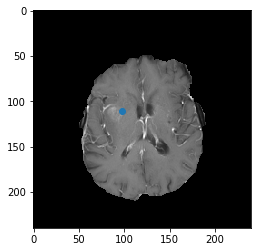

In [ ]:
# Test Image Index
N_test = 20

plt.imshow(np.squeeze(imgTest[N_test],axis=2),cmap='gray')
#plt.scatter(np.round(predictions[N_test,0]),np.round(predictions[N_test,0]),s=20,c='red')
plt.scatter(predictions[N_test,0], predictions[N_test,1])
#plt.scatter(44,70,s=20,c='red')

***Analysing Model Predictions***

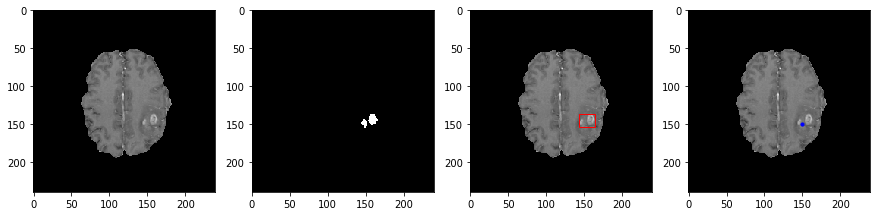

In [ ]:
Ntest = 1

imgSlice = np.squeeze(imgTest[Ntest,...],axis=2)
imgMaskSlice = np.squeeze(imgMaskTest[Ntest,...],axis=2)
mask_bbox = bbTest[Ntest,:]

fig, ax = plt.subplots(nrows=1, ncols=4)

fig.set_figheight(15)
fig.set_figwidth(15)


ax[0].imshow(imgSlice, cmap='gray')
ax[1].imshow(imgMaskSlice, cmap='gray')
ax[2].imshow(imgSlice, cmap='gray')
rect = patches.Rectangle((mask_bbox[2],mask_bbox[3]),(mask_bbox[0]-mask_bbox[2]),(mask_bbox[1]-mask_bbox[3]),linewidth=1,edgecolor='r',facecolor='none')
ax[2].add_patch(rect)
ax[3].imshow(imgSlice, cmap='gray')

plt.scatter(predictions[Ntest,0], predictions[Ntest, 1],s=10,c='b')
plt.show()


# **Plotting the ROC Curve**
The True positive is considered as the point that lies in +or- 15 pixels around the ground truth, The False positive is considered as a point which lies outside the Region of intrest, The test is done on the prediction of the test images , A graph is plotted between normalized True positive and False positive.

In [ ]:
import time
from google.colab.patches import cv2_imshow as im
g = np.linspace(1,20,100)
True_Positive = []
False_Positive = []
for j in g:
  count = 0
  for i in range(len(imgTest)):
    n = j
    if n == 0:
      dst = imgTest[i]
    else:
      kernel = np.ones((int(n),int(n)),np.float32)/n**2
      dst = cv2.filter2D(imgTest[i], -1, kernel)
      dst = np.expand_dims(dst,axis=3)

    u = model.predict(np.array([dst]))[0]*240
    x1, y1 = u[0], u[1]
    mask_bbox = bbTest[i,:]
    x, y = predictions[i,0], predictions[i,1]
    a = mask_bbox[0]
    b = mask_bbox[1]
    c = mask_bbox[2]
    d = mask_bbox[3]
    if a - 15< x1 < c + 15 and b - 15 < y1 < d + 15:
      count += 1
  True_Positive.append(count/100)
  False_Positive.append((100-count)/100)
    

print(True_Positive.sort())
print(False_Positive.sort())
True_Positive = [0] + True_Positive + [1.0]
False_Positive = [0] + False_Positive + [1.0]






***PLOTTER***

Text(0.5, 1.0, 'ROC Curve')

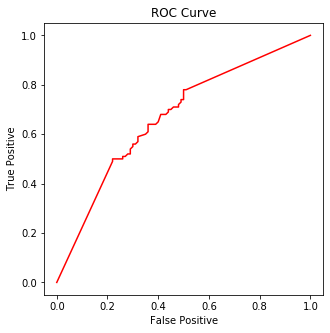

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)

fig.set_figheight(5)
fig.set_figwidth(5)

ax.plot(False_Positive, True_Positive , c = "r")
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.title("ROC Curve")